In [2]:
import sys
import random
import warnings
import numpy as np
import torch
import torch.nn as nn  # PyTorch Lightning NN (neural network) module
import torchvision
from torch.utils.data import DataLoader
import torchdata
import lightning as L
from ceruleanml.data_pipeline import put_image_in_dict, get_src_pths_annotations
from transformers import Mask2FormerForUniversalSegmentation, Mask2FormerConfig
import os
#for debugging
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
if not sys.warnoptions:
    warnings.simplefilter("ignore")
# Set the random seed
seed=0 # we need to set this for torch datapipe separately
random.seed(seed)
torch.set_float32_matmul_precision('medium') # if you have tensor cores

ModuleNotFoundError: No module named 'numpy'

Loading the train and validation set

In [2]:
train_dir = "/home/work/slickformer/data/partitions/train_tiles_context_0/"
train_imgs, train_annotations = get_src_pths_annotations(train_dir)
val_dir = "/home/work/slickformer/data/partitions/val_tiles_context_0/"
val_imgs, val_annotations = get_src_pths_annotations(val_dir)
test_dir = "/home/work/slickformer/data/partitions/test_tiles_context_0/"

Setting up the datapipes

In [3]:
train_i_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[train_annotations])
train_l_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[train_annotations])
train_source_pipe_processed = (
    train_i_coco_pipe.get_scene_paths(train_dir)  # get source items from the collection
    .read_tiff()
)

In [4]:
train_labels_pipe_processed = (
    train_l_coco_pipe.decode_masks()
)

In [5]:
%%time
next(iter(train_labels_pipe_processed))

CPU times: user 547 ms, sys: 31.3 ms, total: 578 ms
Wall time: 595 ms


{'masks': [array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)],
 'labels': [3],
 'image_name': 'S1B_IW_GRDH_1SDV_20210723T164019_20210723T164044_027924_0354FB_5BDF.tif'}

In [6]:
train_labels_pipe_processed = (
    train_l_coco_pipe.read_masks("/home/work/slickformer/data/partitions/train_tiles_context_0/tiled_masks")
)

In [7]:
%%time
next(iter(train_labels_pipe_processed))

CPU times: user 505 ms, sys: 15.2 ms, total: 520 ms
Wall time: 537 ms


{'masks': [array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)],
 'labels': [3],
 'image_name': 'S1B_IW_GRDH_1SDV_20210723T164019_20210723T164044_027924_0354FB_5BDF.tif'}

We'll train on random crops of masks to focus on the most informative parts of scene for more efficient training.

In [8]:
train_dp = (
    train_source_pipe_processed.zip(train_labels_pipe_processed)
    .random_crop_mask_if_exists(512,512)
    .channel_first_norm_to_tensor()
)

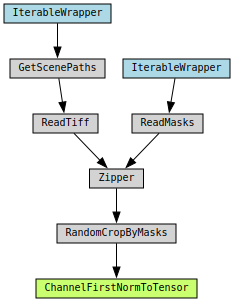

In [9]:
torchdata.datapipes.utils.to_graph(dp=train_dp)

Putting datapipes in a pytorch-lightning DataModule

In [10]:
import matplotlib.pyplot as plt

def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    return {"pixel_values": pixel_values, "pixel_mask": pixel_mask, "class_labels": class_labels, "mask_labels": mask_labels}


class Mask2FormerDataModule(L.LightningDataModule):
    def __init__(self, config_path, train_dir, val_dir, test_dir, batch_size, num_workers, crop_size=512):
        super().__init__()
        self.train_dir, self.val_dir, self.test_dir = train_dir, val_dir, test_dir
        self.bs = batch_size
        self.num_workers = num_workers
        self.crop_size = crop_size
        self.config_path = config_path

    def setup(self, stage):
        if stage is not None:  # train/val/test/predict
            train_imgs, train_annotations = get_src_pths_annotations(self.train_dir)
            train_i_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[train_annotations])
            train_l_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[train_annotations])
            train_source_pipe_processed = (
                train_i_coco_pipe.get_scene_paths(self.train_dir)  # get source items from the collection
                .read_tiff()
            )
            train_labels_pipe_processed = (
                train_l_coco_pipe.decode_masks()
            )
            self.train_dp = (
                train_source_pipe_processed.zip(train_labels_pipe_processed)
                .random_crop_mask_if_exists(self.crop_size, self.crop_size)
                .channel_first_norm_to_tensor()
                .remap_remove()
            )
            # TODO if val processing mirrors train processing, this could be factored out to a func
            val_imgs, val_annotations = get_src_pths_annotations(self.val_dir)
            val_i_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[val_annotations])
            val_l_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[val_annotations])
            val_source_pipe_processed = (
                val_i_coco_pipe.get_scene_paths(self.val_dir) # get source items from the collection
                .  read_tiff()
            )
            val_labels_pipe_processed = (
                val_l_coco_pipe.decode_masks()
            )
            self.val_dp = (
                val_source_pipe_processed.zip(val_labels_pipe_processed)
                .random_crop_mask_if_exists(self.crop_size,self.crop_size)
                .channel_first_norm_to_tensor()
                .remap_remove()
            )

            test_imgs, test_annotations = get_src_pths_annotations(self.test_dir)
            test_i_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[test_annotations])
            test_l_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[test_annotations])
            test_source_pipe_processed = (
            test_i_coco_pipe.get_scene_paths(self.test_dir) # get source items from the collection
                .read_tiff()
                .map(put_image_in_dict)
            )
            test_labels_pipe_processed = (
                test_l_coco_pipe.decode_masks()
            )
            self.test_dp = (
            test_source_pipe_processed.zip(test_labels_pipe_processed)
            .combine_src_label_dicts() # we don't crop for the test set TODO, do we also not crop for validation?
            .channel_first_norm_to_tensor()
            .remap_remove()
            )

    def graph_dp(self):
        return torchdata.datapipes.utils.to_graph(dp=self.train_dp)

    def show_batch(self, channel=0):
        """
        channel 0 - vv radar
        channel 1 infra distance
        channel 2 historical vessel traffic

        """
        assert channel in [0,1,2]

        def closest_factors(n):
            factor1 = int(n**0.5)
            factor2 = n // factor1
            while factor1 * factor2 != n:
                factor1 -= 1
                factor2 = n // factor1
            return factor1, factor2

        nrows, ncols = closest_factors(self.bs)
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
        
        for item, ax in zip(self.train_dp, fig.axes):
            if channel == 0:
                vv_db_units = np.log10(np.array(item["image"][channel,:,:])) * 10
            else:
                vv_db_units = np.array(item["image"][channel,:,:])
            vv_db_units[vv_db_units == -np.inf] = np.nan
            min_value = np.nanpercentile(vv_db_units, 5)
            max_value = np.nanpercentile(vv_db_units, 95)
            rescaled = (vv_db_units - min_value) / (max_value - min_value)
            im = ax.imshow(rescaled)
            
            # Create an individual colorbar for the current image
            cbar = fig.colorbar(im, ax=ax, shrink=0.7)
            
            # Set the number of ticks on the colorbar
            cbar.locator = MaxNLocator(nbins=5)
            cbar.update_ticks()

            # Format the tick labels
            tick_formatter = FuncFormatter(lambda x, pos: f'{min_value + x * (max_value - min_value):.2f}')
            cbar.ax.yaxis.set_major_formatter(tick_formatter)

        plt.tight_layout()

    def train_dataloader(self):
        train_dp_batched, _ = self.train_dp.m2fprocessor(self.config_path).batch(self.bs).map(collate_fn).random_split(total_length=10, seed =0)
        return DataLoader(num_workers= self.num_workers, pin_memory=True, dataset=train_dp_batched, batch_size=None)

    def val_dataloader(self):
        val_dp_batched = self.val_dp.m2fprocessor(self.config_path).batch(self.bs).map(collate_fn)
        return DataLoader(num_workers= self.num_workers, pin_memory=True, dataset=val_dp_batched, batch_size=None)

    def test_dataloader(self):
        test_dp_batched = self.test_dp.m2fprocessor(self.config_path).batch(self.bs).map(collate_fn)
        return DataLoader(num_workers= self.num_workers, pin_memory=True, dataset=test_dp_batched, batch_size=None)

    def predict_dataloader(self):
        test_dp_batched = self.test_dp.m2fprocessor(self.config_path).batch(self.bs).map(collate_fn)
        return DataLoader(num_workers= self.num_workers, pin_memory=True, dataset=test_dp_batched, batch_size=None)

In [11]:
data_config_path= "/home/work/slickformer/custom_processors/preprocessor_config.json"
onef_dm = Mask2FormerDataModule(data_config_path, train_dir, val_dir, test_dir, batch_size=10, num_workers=os.cpu_count() - 1, crop_size=512)
# 10 is limit for 24 Gb gpu memory and 512 crop size

In [14]:
train_dp_batched, _ = train_dp.m2fprocessor(data_config_path).batch(10).map(collate_fn).random_split(total_length=10, weights = {"train":1, "valid":0},seed =0)

In [15]:
%%time

x = next(iter(train_dp.remap_remove().m2fprocessor(data_config_path)))

CPU times: user 770 ms, sys: 183 ms, total: 953 ms
Wall time: 840 ms


In [16]:
%%time

x=next(iter(train_dp.remap_remove()))

CPU times: user 1.15 s, sys: 61.3 ms, total: 1.21 s
Wall time: 701 ms


for some reason this errors after batch.... might want to go back to long iteration over all batches commit.  doe sthis happen with random split?

In [18]:
%%time

for i in train_dp_batched:
    pass

TypeError: zeros_like(): argument 'input' (position 1) must be Tensor, not numpy.ndarray
This exception is thrown by __iter__ of Mask2FormerProcessorDP(kwargs={}, sample_dicts=ChannelFirstNormToTensor)

In [22]:
%%time

x = next(iter(train_labels_pipe_processed))

CPU times: user 2.81 s, sys: 58.4 ms, total: 2.86 s
Wall time: 2.91 s


In [23]:
x

{'masks': [array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)],
 'labels': [3],
 'image_name': 'S1B_IW_GRDH_1SDV_20210723T164019_20210723T164044_027924_0354FB_5BDF.tif'}

In [20]:
from tifffile import imwrite
masks_dir = "./tiled_masks"
for i in train_labels_pipe_processed:
    save_masks_to_tiff(i['masks'], masks_dir, i['image_name'])


In [17]:
# Function to save the masks
def save_masks_to_tiff(masks, masks_dir, image_name):
    mask_stack = np.stack(masks, axis=-1)  # stack along the channel axis
    mask_path = os.path.join(masks_dir, f"{image_name[-4:]}_mask.tif")
    imwrite(mask_path, mask_stack)


In [9]:
pth = 'S1A_IW_GRDH_1SDV_20200729T021511_20200729T021536_033663_03E6CA_2CFE.tif'

In [12]:
pth[-4:]

'.tif'

In [ ]:
onef_dm.setup(stage="train") #what's the purpose of stage?

In [ ]:
from matplotlib.ticker import MaxNLocator, FuncFormatter

onef_dm.show_batch(0)

In [ ]:
for i in onef_dm.train_dataloader():
    i
    break

In [ ]:
from transformers import AdamW
class Backbone(nn.Module):
    def __init__(
        self, model_name, in_chans, num_classes, pretrained, global_pool, drop_rate
    ):
        super().__init__()
        # loads from huggingface if not downloaded
        
        #by default the above method sets eval mode, set to training
        self.backbone.train()

    def forward(self, xb):
        return self.backbone(xb)

class Mask2FormerLightningModel(L.LightningModule):
    def __init__(
        self,
        config_path,
        learning_rate: float = 2e-5,
        adam_epsilon: float = 1e-8,
        warmup_steps: int = 0,
        weight_decay: float = 0.0,
    ):
        super().__init__()
        self.save_hyperparameters()  # saves all hparams as self.hparams
        # can try other universal segmentation models: https://github.com/huggingface/transformers/pull/20766/files#r1050493186
        config = Mask2FormerConfig.from_pretrained(config_path, ignore_mismatched_sizes=True) 
        self.model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-small-cityscapes-panoptic", config=config, cache_dir="./model_cache", ignore_mismatched_sizes=True)
        #by default the above method sets eval mode, set to training
        self.model.train()
        # Move the model to the default CUDA device (if available)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)

    def forward(self, xb):
        return self.model(xb)

    def one_step(self, batch):
        # potential edge case, we squash instance masks to semantic masks. it's possible to lose 
        # mask label 3 from mask but not class labels since we don't edit class labels
        #self.model.train() # for some reason this needs to be set here, not picked up in init
        outputs = self.model(pixel_values=batch["pixel_values"], mask_labels=batch["mask_labels"], class_labels=batch['class_labels'])
        return outputs.loss
    
    def configure_optimizers(self):
        """Prepare optimizer and schedule (linear warmup and decay)"""
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        return [optimizer]

    def training_step(self, batch, batch_idx):
        loss = self.one_step(batch)
        self.log("trn_loss", loss, on_step=True, on_epoch=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.one_step(batch)
        self.log("val_loss", loss, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        loss, score = self.one_step(batch)
        self.log("tst_loss", loss, prog_bar=True, logger=True)

In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.profilers import AdvancedProfile, SimpleProfiler

profiler = SimpleProfiler(dirpath=".", filename="perf_logs")
logger = TensorBoardLogger("tb_logs", name="my_model")

trainer = L.Trainer(
    max_epochs = 5,
    accelerator="auto",
    devices = 1 if torch.cuda.is_available else None,
    logger=logger,
    profiler=profiler
    # deterministic=True # can't set this when using cuda
)

In [ ]:
model_config_path= "/home/work/slickformer/custom_models/config.json"
model = Mask2FormerLightningModel(model_config_path)

need to run this in terminal because for some reason created dirs are owned by root even though docker container built for user 1000

In [ ]:
trainer.fit(model, datamodule=onef_dm)
print(profiler.summary())

In [ ]:
# from transformers import  AutoImageProcessor, MaskFormerForInstanceSegmentation
# image_processor = AutoImageProcessor.from_pretrained("facebook/maskformer-swin-base-coco", num_labels=3)
# instance_inputs = image_processor(images=data['image'], return_tensors="pt")
# for k,v in instance_inputs.items():
#   print(k,v.shape)


# from collections import defaultdict
# import matplotlib.pyplot as plt
# from matplotlib import cm
# import matplotlib.patches as mpatches

# def draw_panoptic_segmentation(segmentation, segments_info):
#     # get the used color map
#     viridis = cm.get_cmap('viridis', torch.max(segmentation))
#     fig, ax = plt.subplots()
#     ax.imshow(segmentation)
#     instances_counter = defaultdict(int)
#     handles = []
#     # for each segment, draw its legend
#     for segment in segments_info:
#         segment_id = segment['id']
#         segment_label_id = segment['label_id']
#         segment_label = model.config.id2label[segment_label_id]
#         label = f"{segment_label}-{instances_counter[segment_label_id]}"
#         instances_counter[segment_label_id] += 1
#         color = viridis(segment_id)
#         handles.append(mpatches.Patch(color=color, label=label))
        
#     ax.legend(handles=handles)
#     plt.savefig('cats_panoptic.png')

# draw_panoptic_segmentation(**panoptic_segmentation)

# # %%


# # %%


# # %%


# # %%


# # %%


# # %% [markdown]
# # Groundtruth datapipe with non cropped images. We will use these for inference with the trained model.

# # %%
# gt_train_dp = (train_dp
#                     .map(evaluation.remap_gt_dict)
#                     .map(evaluation.stack_boxes)
# )

# # %%
# from torchmetrics import detection

# m = detection.mean_ap.MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[.5], rec_thresholds=None, max_detection_thresholds=None, class_metrics=True)

# m.update(preds=[pred_dict_thresholded_nms], target=[test_sample])

# from pprint import pprint
# pprint(m.compute())